# Additional Plots

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib.colors import to_rgba

## Polar plots

In [2]:
# Read in preprocessed bike data
bike_data = pd.read_csv("../data/full_bike_data_preprocessed.csv", low_memory=False) 
bike_data['timestamp'] = pd.to_datetime(bike_data['timestamp'], utc = True, errors='coerce').dt.tz_convert('Europe/Berlin')

In [3]:
# Get data for specific city
city = "Stadt Tübingen" # Select city
city_data = bike_data[bike_data['city'] == city]

In [4]:
# Style configurations for counter
counter_config = {
    'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee': {
        'label': 'Steinlach Tunnel', 'color': '#1f77b4'
    },
    'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee_2': {
        'label': 'Steinlach Tunnel', 'color': '#1f77b4'             
    },
    'Fuß- & Radtunnel Südportal - Derendinger Allee': {
        'label': 'Radtunnel Südportal', 'color': "#2ca02c"
    },
    'Fuß- & Radtunnel Südportal - Derendinger Allee_3': {
        'label': 'Radtunnel Südportal', 'color': '#2ca02c'
    },
    'Neckartalradweg Hirschau - parallel L371': {
        'label': 'Neckartalradweg Hirschau', 'color': '#9467bd'
    },
    'Neckartalradweg Hirschau - parallel L371_3': {
        'label': 'Neckartalradweg Hirschau', 'color': '#9467bd'
    }
}

In [5]:
# Helper functions
def prepare_data(df):
    '''Extracts year, day of year, and hour from timestamp and ensures timezone is Europe/Berlin'''
    if df['timestamp'].dt.tz is None:
        df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize('UTC')
    df['timestamp'] = df['timestamp'].dt.tz_convert('Europe/Berlin')
    
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['weekday'] = df['timestamp'].dt.weekday
    return df

def plot_on_axis(ax, df, period_col, labels, mode):
    '''Plots data on given axis based on mode (monthly_daily_avg or weekday_mean)'''
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    
    counters = df['counter_site'].unique()
    
    for counter in counters:
        settings = counter_config.get(counter, {'label': counter, 'color': 'gray'})
        c_label = settings['label']
        c_color = settings['color']
        
        subset = df[df['counter_site'] == counter]
        years = sorted(subset['year'].unique())
        
        for year in years:
            year_data = subset[subset['year'] == year]
            
            # Aggregate data
            if mode == 'monthly_daily_avg':
                # Calculate Average Hourly Count, then multiply by 24 for Daily Average
                g = year_data.groupby(period_col)['count'].agg(['sum', 'count'])
                # sum = total bikes, count = total hours observed
                # (Total Bikes / Total Hours) * 24 = Average Bikes Per Day
                g['val'] = (g['sum'] / g['count']) * 24
                
                # Reindex ensures we have 12 months, fill missing with NaN (broken line) or 0
                g = g.reindex(range(1, 13), fill_value=None) 
                values = g['val'].fillna(0).tolist() # Use 0 to keep the loop closed, or handle gaps
                
            elif mode == 'weekday_mean':
                g = year_data.groupby(period_col)['count'].mean()
                g = g * 24  # Average daily count
                g = g.reindex(range(0, 7), fill_value=0)
                values = g.tolist()
            
            values += values[:1]
            
            # Plot
            lbl = c_label if year == years[0] else ""
            ax.plot(angles, values, color=c_color, linewidth=1.5, alpha=0.5, label=lbl)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=16)
    ax.tick_params(axis='y', labelsize=12)
    if mode == 'monthly_daily_avg':
        ax.set_rlabel_position(10)

C:\Users\kessl\AppData\Local\Temp\ipykernel_37312\3363975128.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = df['timestamp'].dt.tz_convert('Europe/Berlin')
C:\Users\kessl\AppData\Local\Temp\ipykernel_37312\3363975128.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['timestamp'].dt.year
C:\Users\kessl\AppData\Local\Temp\ipykernel_37312\3363975128.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

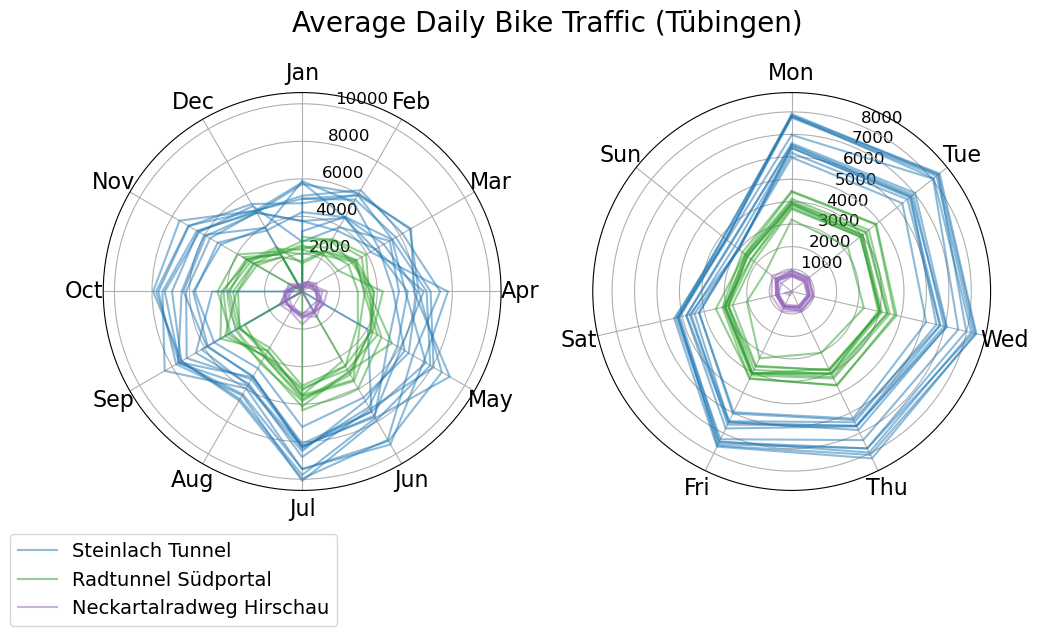

In [6]:
# Plotting
df_prepared = prepare_data(city_data) 

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(10, 5))

# Monthly Average Daily Traffic
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plot_on_axis(ax1, df_prepared, 'month', months, 'monthly_daily_avg')

# Weekday Average Daily Traffic
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot_on_axis(ax2, df_prepared, 'weekday', weekdays, 'weekday_mean')

fig.suptitle("Average Daily Bike Traffic (Tübingen)", fontsize=20, y=1.02, x=0.5)

handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
unique_labels = [lbl for lbl in by_label.keys() if lbl != ""]
unique_handles = [by_label[lbl] for lbl in unique_labels]

fig.legend(unique_handles, unique_labels, loc='center right', bbox_to_anchor=(0.3, -0.12), fontsize=14)
plt.tight_layout()
plt.show()

# Save figure
#fig.savefig("../figures/polar_bike_traffic_tuebingen.png", dpi=300, bbox_inches='tight')

## Heatmaps

In [7]:
# Select specific counter data
selected_counter = ["Wiwilibrücke"]
bike_data_selected = bike_data[bike_data['counter_site'].isin(selected_counter)]

### Heatmap plot with axes time and day of week for selected counter

C:\Users\kessl\AppData\Local\Temp\ipykernel_37312\2177827917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
C:\Users\kessl\AppData\Local\Temp\ipykernel_37312\2177827917.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['weekday'] = bike_data_selected['timestamp'].dt.day_name()


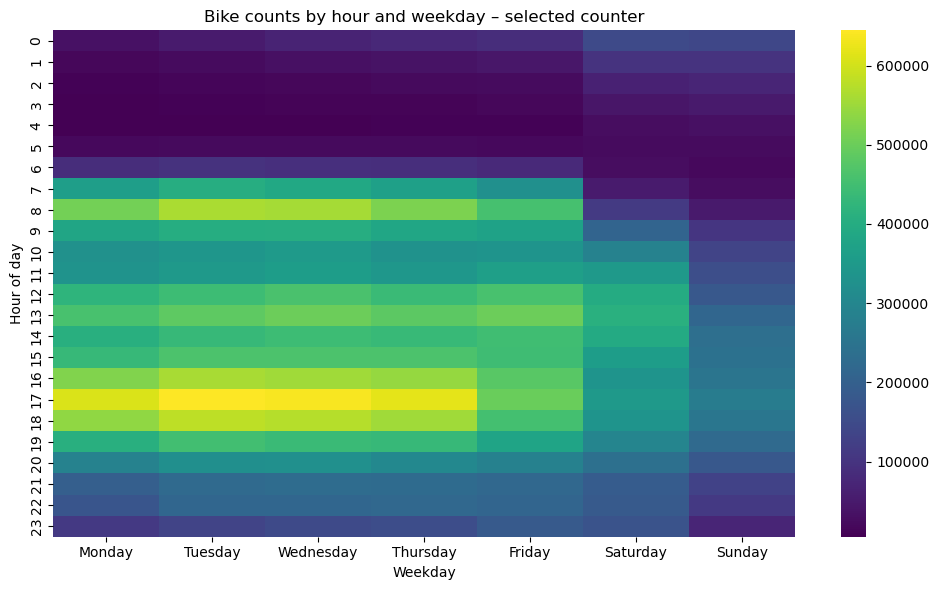

In [8]:
# Extract hour and weekday
bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
bike_data_selected['weekday'] = bike_data_selected['timestamp'].dt.day_name()

# Aggregate counts
heat_df = bike_data_selected.pivot_table(
    index='hour',
    columns='weekday',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Order weekdays Monday–Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heat_df = heat_df.reindex(columns=weekday_order)

plt.figure(figsize=(10, 6))
sns.heatmap(heat_df, cmap='viridis')
plt.title('Bike counts by hour and weekday – selected counter')
plt.xlabel('Weekday')
plt.ylabel('Hour of day')
plt.tight_layout()
plt.show()

### Heatmap plot with axes time and day of year for selected counter

C:\Users\kessl\AppData\Local\Temp\ipykernel_37312\2885902912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
C:\Users\kessl\AppData\Local\Temp\ipykernel_37312\2885902912.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data_selected['day_of_year'] = bike_data_selected['timestamp'].dt.dayofyear


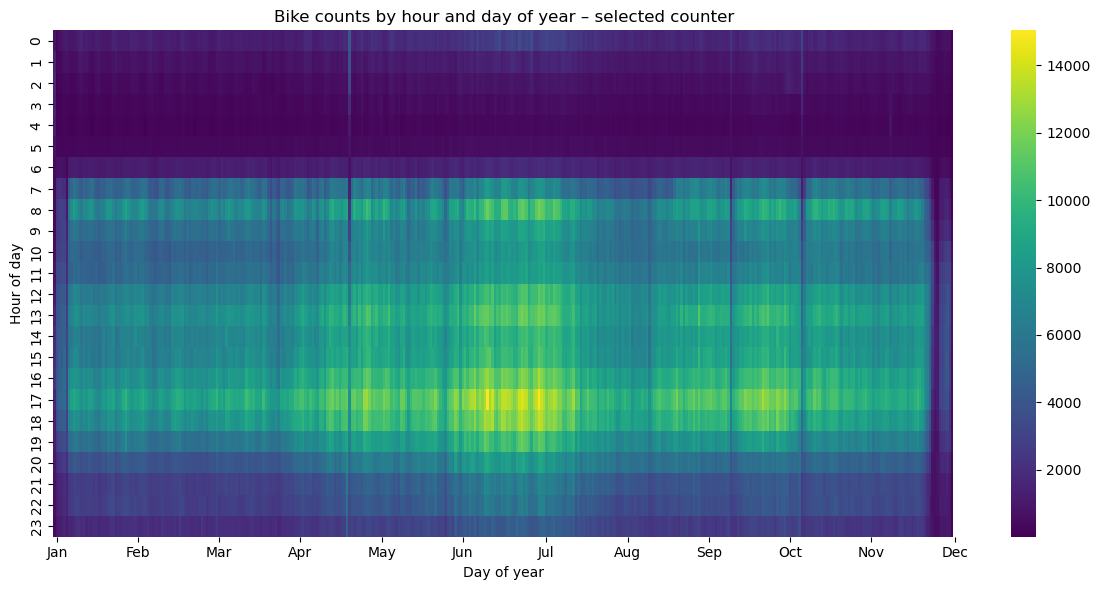

In [9]:
# Extract hour and day of year
bike_data_selected['hour'] = bike_data_selected['timestamp'].dt.hour
bike_data_selected['day_of_year'] = bike_data_selected['timestamp'].dt.dayofyear

# Aggregate counts
heat_df = bike_data_selected.pivot_table(
    index='hour',
    columns='day_of_year',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Spalten nach Tag-im-Jahr sortieren (x-Achse)
heat_df = heat_df.reindex(sorted(heat_df.columns), axis=1)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heat_df, cmap='viridis')
plt.title('Bike counts by hour and day of year – selected counter')
plt.xlabel('Day of year')
plt.ylabel('Hour of day')

# Tick-Positionen und Labels (Monate)
if not heat_df.empty:
    min_day, max_day = heat_df.columns.min(), heat_df.columns.max()
    ticks = np.linspace(min_day, max_day, 12, dtype=int)
    base_year = int(bike_data_selected['timestamp'].dt.year.mode().iloc[0])
    labels = pd.to_datetime(ticks - 1, unit='D', origin=f'{base_year}-01-01').strftime('%b')
    ax.set_xticks(ticks + 0.5)  # center ticks
    ax.set_xticklabels(labels, rotation=0)

plt.tight_layout()
plt.show()

Rain distribution over temperature

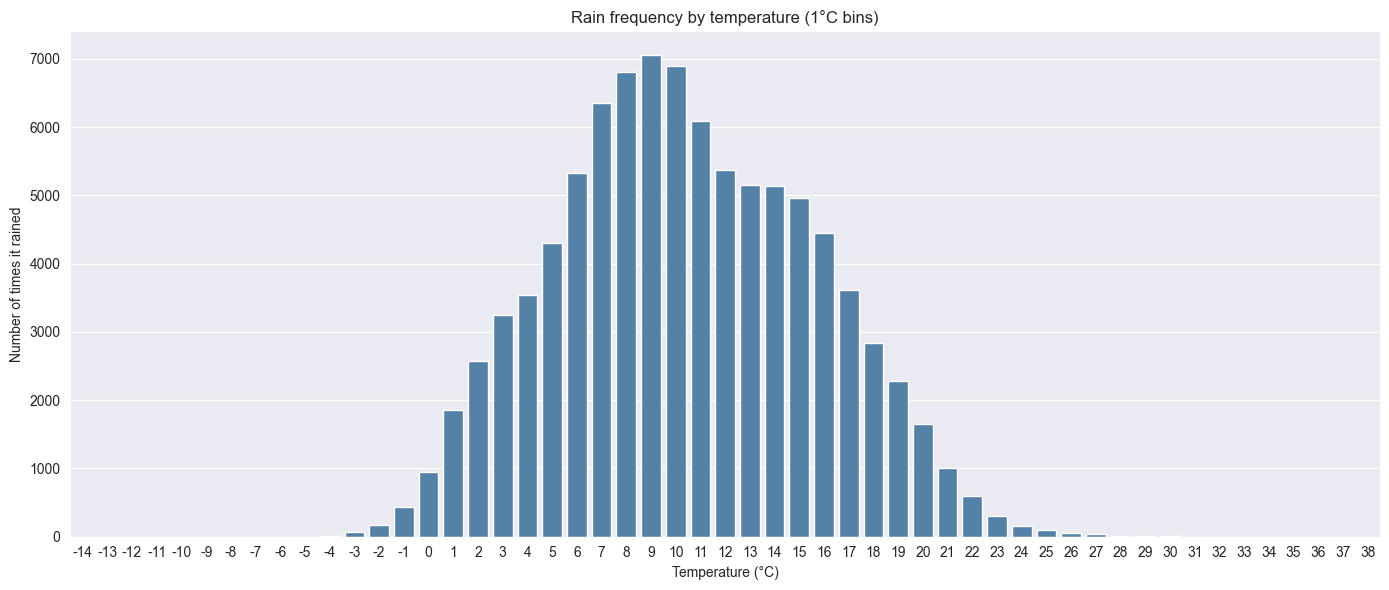

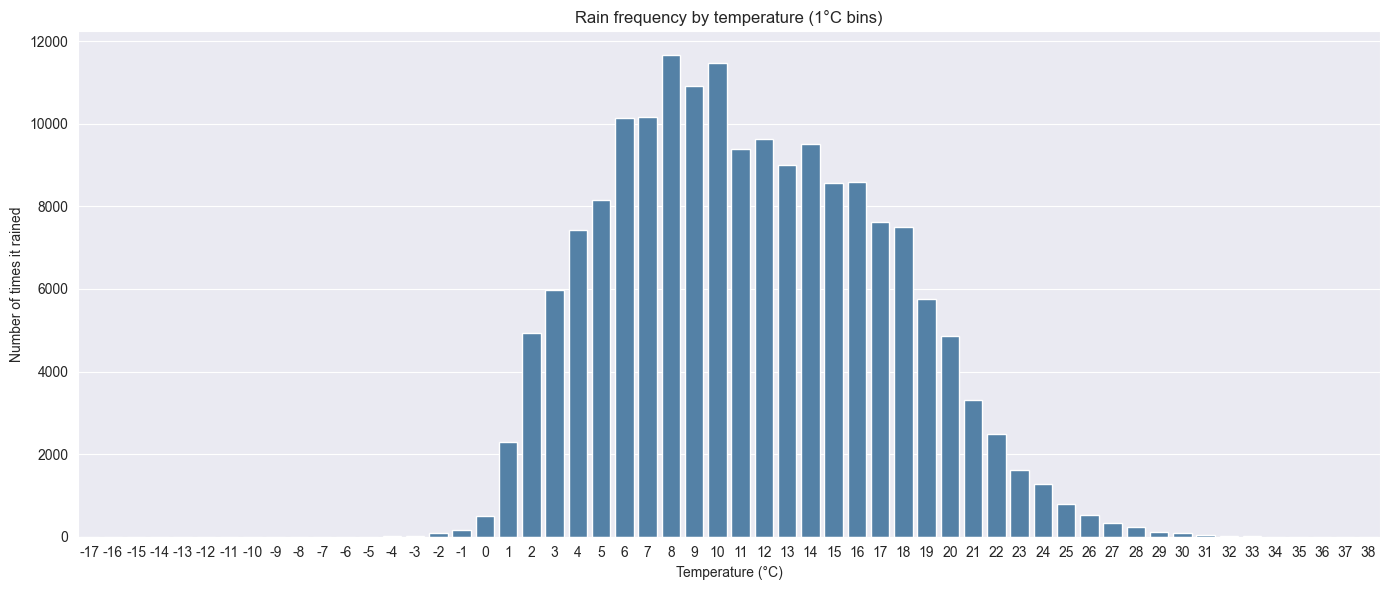

In [3]:
weather_data = pd.read_csv("../data/weather_per_city.csv")

weather_data = weather_data.dropna(subset=["forecast_temperature_2m"])
# Integer temperature per °C
weather_data["temp_c"] = weather_data["forecast_temperature_2m"].round().astype(int)

# Binary rain indicator
weather_data["rained"] = weather_data["forecast_rain"] > 0
rain_counts = (
    weather_data
    .groupby("temp_c")["rained"]
    .sum()
    .reset_index()
)
plt.figure(figsize=(14, 6))
sns.barplot(
    data=rain_counts,
    x="temp_c",
    y="rained",
    color="steelblue"
)

plt.xlabel("Temperature (°C)")
plt.ylabel("Number of times it rained")
plt.title("Rain frequency by temperature (1°C bins)")

# Show every degree (or thin if too dense)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

weather_data["temp_c"] = weather_data["temperature_2m"].round().astype(int)

# Binary rain indicator
weather_data["rained"] = weather_data["rain"] > 0
rain_counts = (
    weather_data
    .groupby("temp_c")["rained"]
    .sum()
    .reset_index()
)
plt.figure(figsize=(14, 6))
sns.barplot(
    data=rain_counts,
    x="temp_c",
    y="rained",
    color="steelblue"
)

plt.xlabel("Temperature (°C)")
plt.ylabel("Number of times it rained")
plt.title("Rain frequency by temperature (1°C bins)")

# Show every degree (or thin if too dense)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

GAMs rain curves

In [2]:
def plot_rain_effect_from_file(path):
    with open(path, "rb") as f:
        results = pickle.load(f)
    rain_grid = results["observed"]["rain_grid"]
    summary_observed = results["observed"]["curves"]
    summary_forecast   = results["forecast"]["curves"]
    bins = results["hist"]["bins"]
    frac_observed = results["hist"]["frac_observed"]
    frac_forecast   = results["hist"]["frac_forecast"]
    temps_fixed = results["meta"]["temps_fixed"]

    #--- Plot ---
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    # Force histograms into background
    ax2.set_zorder(0)
    ax1.set_zorder(1)
    ax1.patch.set_alpha(0)

    observed_colors = ["#084184", "#B23A8A", "#007A5A"]# blue, orange, green
    forecast_colors   = ["#418ac1", "#D46BAF", "#3FAF8A"]  # lighter variants

    # Rain effect curves with CIs
    for T, c_observed, c_forecast in zip(temps_fixed, observed_colors, forecast_colors):
        # observed
        ax1.fill_between(
            rain_grid,
            summary_observed[T]["low"],
            summary_observed[T]["high"],
            color=to_rgba(c_observed, 0.40),
            zorder=2,
        )
        ax1.plot(
            rain_grid,
            summary_observed[T]["mean"],
            lw=2.5,
            color=c_observed,
            label=f"T={T}°C (obs.)",
            zorder=3,
        )
        # forecast
        ax1.fill_between(
            rain_grid,
            summary_forecast[T]["low"],
            summary_forecast[T]["high"],
            color=to_rgba(c_forecast, 0.40),
            zorder=2.5,
        )
        ax1.plot(
            rain_grid,
            summary_forecast[T]["mean"],
            lw=2,
            color=c_forecast,
            label=f"T={T}°C (forecast)",
            zorder=4,
        )
    # -------------------------------------------------
    # Histogram (fractions)
    # -------------------------------------------------
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    width = bins[1] - bins[0]
    h_observed = ax2.bar(
            bin_centers,
            frac_observed,
            width=width,
            color="#808080",
            alpha=0.5,
            align="center",
            label="observed rain",
            zorder=1,
    )
    h_forecast = ax2.bar(
            bin_centers,
            frac_forecast,
            width=width,
            color="#E0E0E0",
            alpha=0.5,
            align="center",
            label="forecast rain",
            zorder=1,
    )
    ax2.set_ylabel("Fraction of all data points")
    ax2.set_ylim(0, max(frac_observed.max(), frac_forecast.max()) * 1.1)
    # -------------------------------------------------
    # Labels, legend, layout
    # -------------------------------------------------
    ax1.set_xlabel("Rain (mm)")
    ax1.set_ylabel("Bike count change relative to 0 mm rain (%)")
    #handles1, labels1 = ax1.get_legend_handles_labels()
    #handles2, labels2 = ax2.get_legend_handles_labels()
    #ax1.legend(
    #        handles1 + handles2,
    #        labels1 + labels2,
    #        loc="upper left",
    #)
    #ax1.set_title("Marginal effect of rain on bike counts\nobserved vs forecast Weather")
    plt.show()

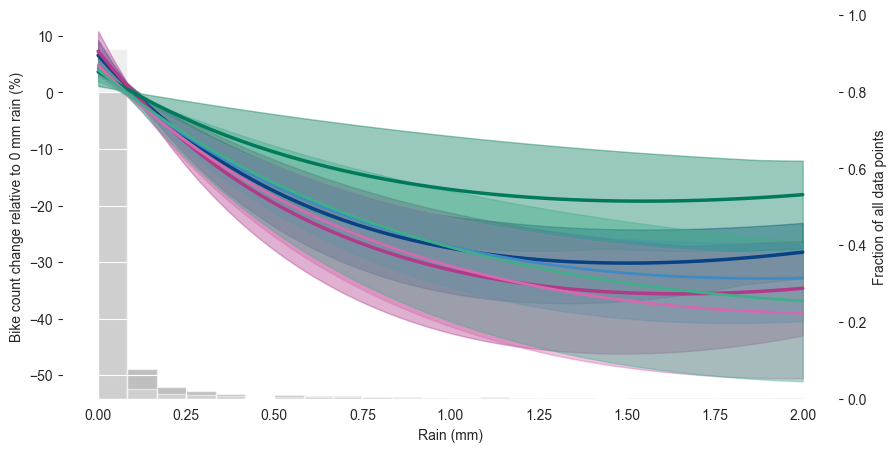

In [4]:
plot_rain_effect_from_file("../data/rain_effect_results.pkl")